In [1]:
# AUTOENCODERS :
# input image --> encoding phase --> code --> decoding phase --> reconstructed image
# APPLICATIONS :
# 1. Noise removal
# 2. Anomaly detection
# 3. domain adaptation (eg - neural style transfer)
# 4. image colorization

In [2]:
from keras.layers import Conv2D, UpSampling2D, Input
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import tensorflow as tf

In [3]:
# specify path to images folder
path = "/content/drive/MyDrive/Image colorizer/Images_flowers"

In [4]:
import os
len(os.listdir('/content/drive/MyDrive/Image colorizer/Images_flowers'))
# number of images

12

In [5]:
train_datagen = ImageDataGenerator(rescale = 1./255) # normalize images
train = train_datagen.flow_from_directory(path,
                                          target_size = (256, 256), 
                                          batch_size = 340,
                                          class_mode = None)

Found 866 images belonging to 12 classes.


In [6]:
train

In [7]:
# convert images from rgb to lab
# LAB images - think of it as a grey image in L channel with all color info stored
# in A and B channel. The input to the network will be the L channel, so we assign
# L channel to X vector and A and B channel to Y vector.

# L contains lightness info - b&w channel
# A axis goes from green to red
# B axis goes from blue to yellow

In [12]:
img = load_img('/content/drive/MyDrive/Image colorizer/new_flowers/roses27.jpg')
lab = rgb2lab(img)
L = lab[:,:,0]
A = lab[:,:,1]
B = lab[:,:,2]

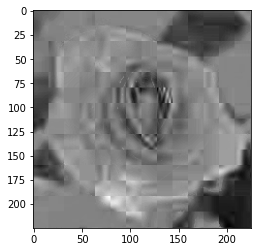

In [13]:
import matplotlib.pyplot as plt
plt.imshow(A, cmap = 'gray')

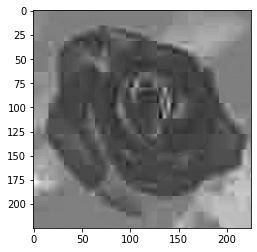

In [14]:
plt.imshow(B, cmap = 'gray')

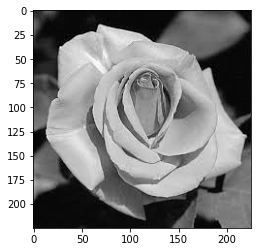

In [15]:
plt.imshow(L, cmap = 'gray')

In [16]:
X = []
Y = []
for img in train[0]:
    lab = rgb2lab(img)
    X.append(lab[:,:,0])
    Y.append(lab[:,:,1:]/128) # A and B values range from -127 to 128, so we divide the 
    # values by 128 to restrict values to b/w -1 and 1.
X = np.array(X)
Y = np.array(Y)
X = X.reshape(X.shape+(1,)) # dimensions to be same for X and Y
print(X.shape)
print(Y.shape)

(340, 256, 256, 1)
(340, 256, 256, 2)


In [17]:
# ENCODER
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2, input_shape=(256, 256, 1)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3,3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))

In [18]:
# DECODER
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
# we are using tanh instead of relu in last layer - since we are colorizing the images in this layer using 2 filters, A and B.
# A and B values range between -1 and 1 so tanh (or hyperbolic tangent) is used as it also has the range between -1 and 1. 
# other functions go from 0 to 1
model.add(UpSampling2D((2, 2)))
model.compile(optimizer='adam', loss='mse' , metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 256)       295168    
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 256)       590080    
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 512)       1180160   
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 512)       2

In [19]:
model.fit(X,Y,validation_split=0.1, epochs=15, batch_size=16)

Epoch 1/15
20/20 [==============================] - 26s 463ms/step - loss: 1.0162 - accuracy: 0.3536 - val_loss: 0.0388 - val_accuracy: 0.3878
Epoch 2/15
20/20 [==============================] - 6s 315ms/step - loss: 0.0345 - accuracy: 0.6134 - val_loss: 0.0239 - val_accuracy: 0.6122
Epoch 3/15
20/20 [==============================] - 6s 316ms/step - loss: 0.0321 - accuracy: 0.6660 - val_loss: 0.0237 - val_accuracy: 0.6122
Epoch 4/15
20/20 [==============================] - 6s 316ms/step - loss: 0.0319 - accuracy: 0.6660 - val_loss: 0.0244 - val_accuracy: 0.6122
Epoch 5/15
20/20 [==============================] - 6s 320ms/step - loss: 0.0319 - accuracy: 0.6660 - val_loss: 0.0238 - val_accuracy: 0.6122
Epoch 6/15
20/20 [==============================] - 6s 317ms/step - loss: 0.0320 - accuracy: 0.6548 - val_loss: 0.0235 - val_accuracy: 0.6121
Epoch 7/15
20/20 [==============================] - 6s 321ms/step - loss: 0.0319 - accuracy: 0.6506 - val_loss: 0.0268 - val_accuracy: 0.6122
Epoch

In [20]:
model.save('/content/drive/MyDrive/Image colorizer/Flower_models/colorize_autoencoder_15_epochs')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Image colorizer/Flower_models/colorize_autoencoder_15_epochs/assets


In [21]:
# LOAD SAVED MODEL AND TEST ON NEW IMAGES 

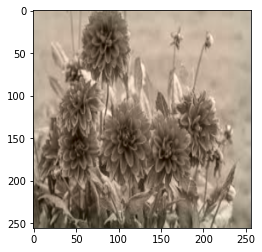

In [23]:
img1_color = []
img1 = img_to_array(load_img('/content/drive/MyDrive/Image colorizer/Images_flowers/Dahlias/Dahlia flowers15.jpg'))
img1 = resize(img1, (256, 256))
img1_color.append(img1)

img1_color = np.array(img1_color, dtype = float)
img1_color = rgb2lab(1.0/255*img1_color)[:,:,:,0]
img1_color = img1_color.reshape(img1_color.shape+(1,))

output1 = model.predict(img1_color)
output1 = output1*128

result = np.zeros((256, 256, 3))
result[:,:,0] = img1_color[0][:,:,0]
result[:,:,1:] = output1[0]
plt.imshow(lab2rgb(result))